In [1]:
from evaluation import get_prompt_list
unique_token = "backpack</w>"
class_token = "backpack"
prompt_list = get_prompt_list(unique_token, class_token, mode = "object")

In [2]:
import sys
sys.path.append("../")
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
from lora_diffusion import tune_lora_scale, patch_pipe
import open_clip
from PIL import Image
from disen_net import Image_adapter
import os

model_id = "/DATA/DATANAS1/zhangyip/models/stable-diffusion-2-1-base"

with torch.no_grad():
    pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")
    img_model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
    img_model = img_model.to("cuda")

/home/chenhong/.conda/envs/diffusion/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [3]:
dir_path = "./output_dreambooth/our_versions/my_base_global0.01/checkpoint"
patch_pipe(
    pipe,
    os.path.join(dir_path, "lora_weight_e249_s1500.pt"),
    patch_text=False,
    patch_ti=False,
    patch_unet=True,
)
tune_lora_scale(pipe.unet, 1.0)
adapter = Image_adapter().to("cuda")
info = torch.load(os.path.join(dir_path, "lora_weight_e249_s1500.img_adapter.pt"))
adapter.load_state_dict(info)
ref_image = preprocess(Image.open("/DATA/DATANAS1/chenhong/diffusion_research/dreambooth_data/backpack/01.jpg")).unsqueeze(0).to("cuda")

LoRA : Patching Unet


## Generation for Dreambooth
First set a random seed, and then the template used in dreambooth will be generated

  0%|          | 0/50 [00:00<?, ?it/s]

0 a backpack</w> backpack in the jungle


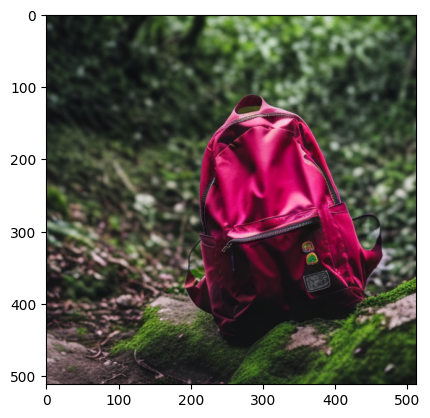

  0%|          | 0/50 [00:00<?, ?it/s]

1 a backpack</w> backpack in the snow


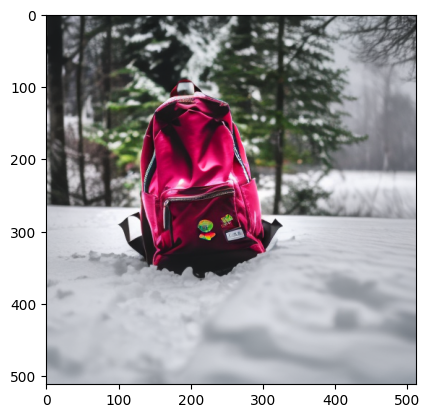

  0%|          | 0/50 [00:00<?, ?it/s]

2 a backpack</w> backpack on the beach


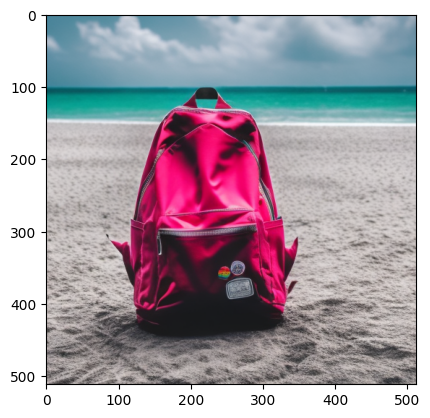

  0%|          | 0/50 [00:00<?, ?it/s]

3 a backpack</w> backpack on a cobblestone street


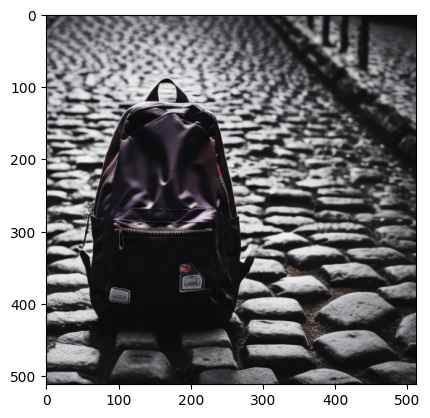

  0%|          | 0/50 [00:00<?, ?it/s]

4 a backpack</w> backpack on top of pink fabric


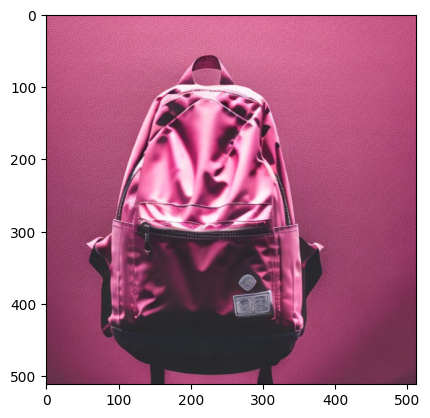

  0%|          | 0/50 [00:00<?, ?it/s]

5 a backpack</w> backpack on top of a wooden floor


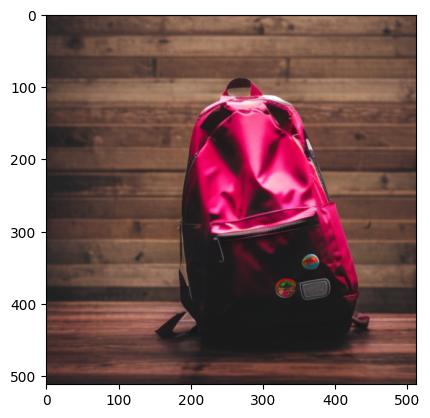

  0%|          | 0/50 [00:00<?, ?it/s]

6 a backpack</w> backpack with a city in the background


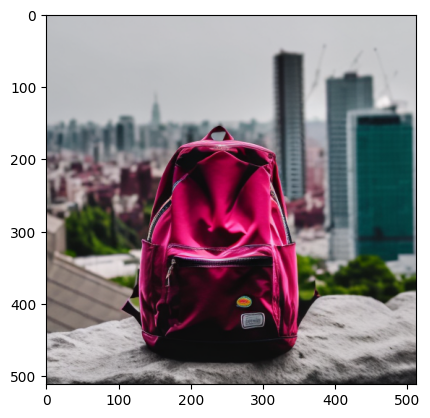

  0%|          | 0/50 [00:00<?, ?it/s]

7 a backpack</w> backpack with a mountain in the background


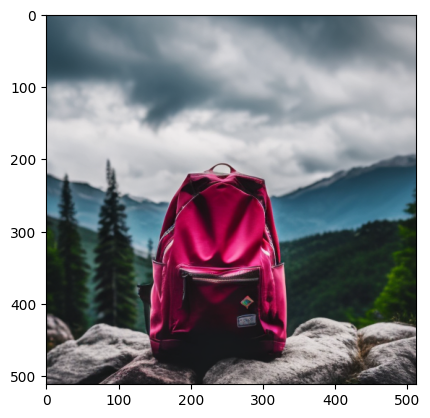

  0%|          | 0/50 [00:00<?, ?it/s]

8 a backpack</w> backpack with a blue house in the background


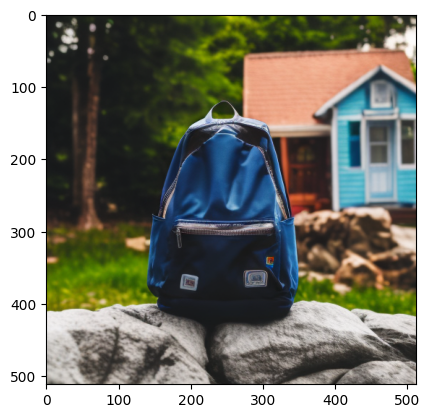

  0%|          | 0/50 [00:00<?, ?it/s]

9 a backpack</w> backpack on top of a purple rug in a forest


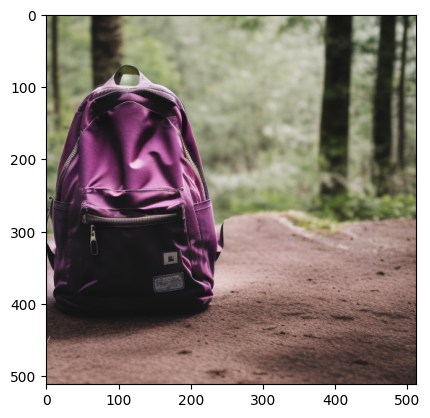

  0%|          | 0/50 [00:00<?, ?it/s]

10 a backpack</w> backpack with a wheat field in the background


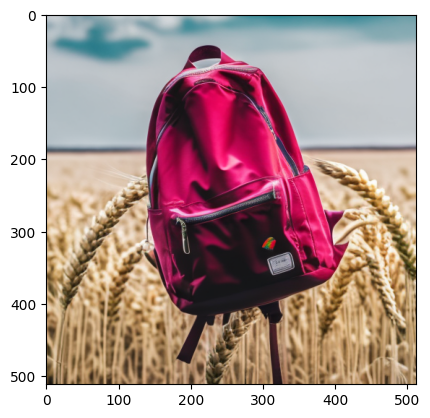

  0%|          | 0/50 [00:00<?, ?it/s]

11 a backpack</w> backpack with a tree and autumn leaves in the background


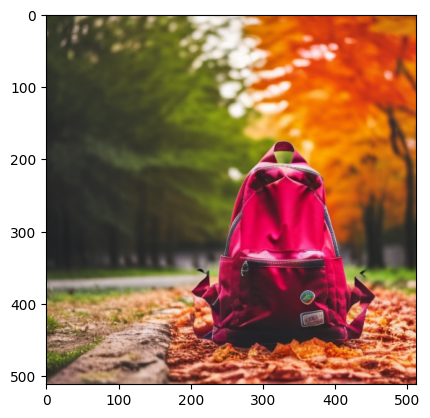

  0%|          | 0/50 [00:00<?, ?it/s]

12 a backpack</w> backpack with the Eiffel Tower in the background


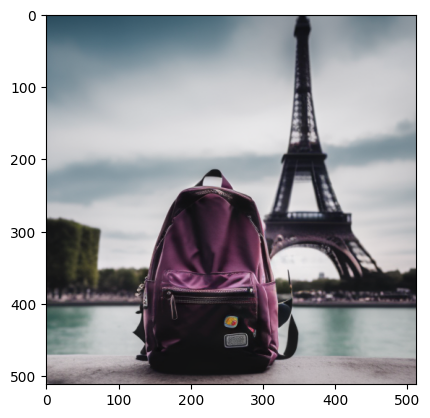

  0%|          | 0/50 [00:00<?, ?it/s]

13 a backpack</w> backpack floating on top of water


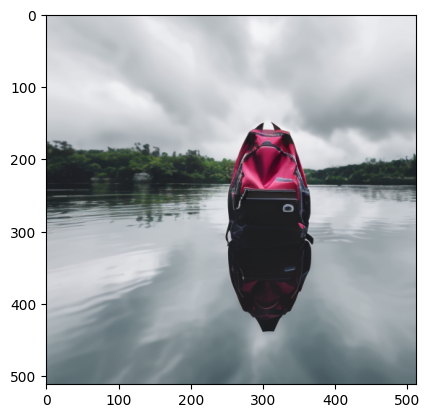

  0%|          | 0/50 [00:00<?, ?it/s]

14 a backpack</w> backpack floating in an ocean of milk


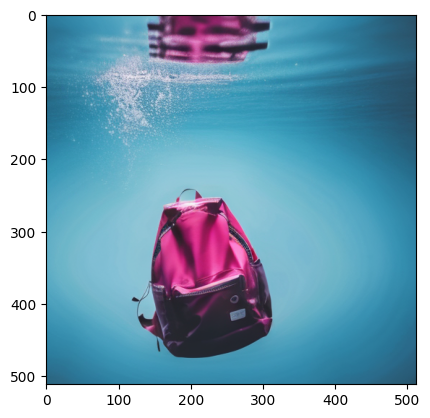

  0%|          | 0/50 [00:00<?, ?it/s]

15 a backpack</w> backpack on top of green grass with sunflowers around it


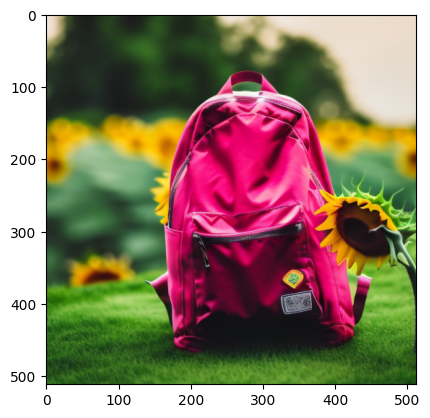

  0%|          | 0/50 [00:00<?, ?it/s]

16 a backpack</w> backpack on top of a mirror


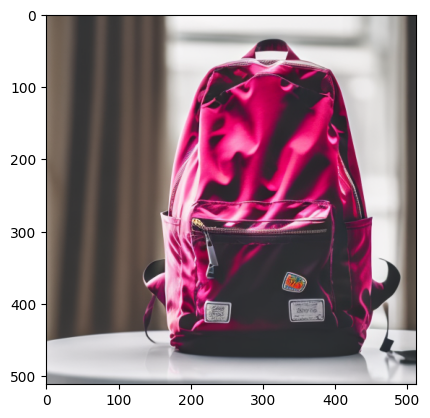

  0%|          | 0/50 [00:00<?, ?it/s]

17 a backpack</w> backpack on top of the sidewalk in a crowded street


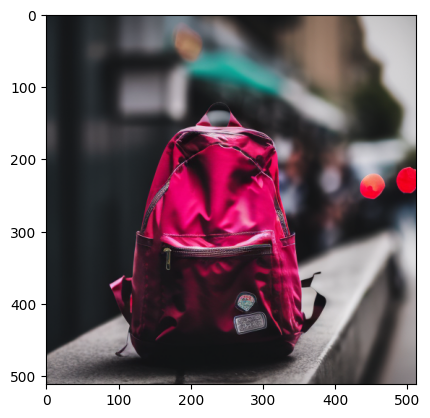

  0%|          | 0/50 [00:00<?, ?it/s]

18 a backpack</w> backpack on top of a dirt road


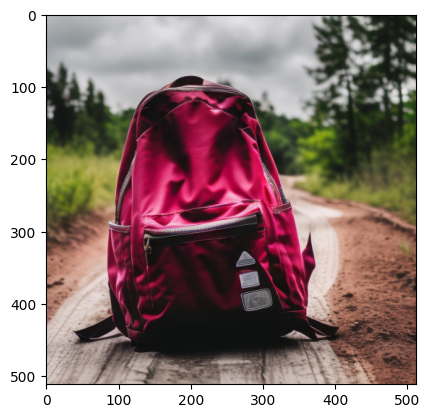

  0%|          | 0/50 [00:00<?, ?it/s]

19 a backpack</w> backpack on top of a white rug


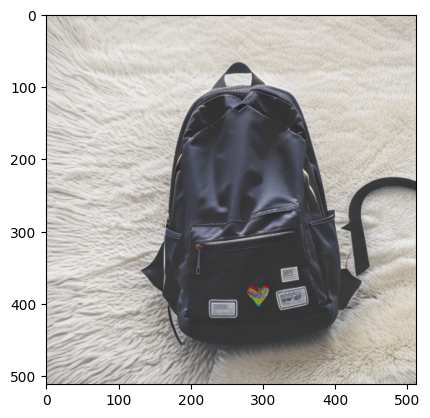

  0%|          | 0/50 [00:00<?, ?it/s]

20 a red backpack</w> backpack


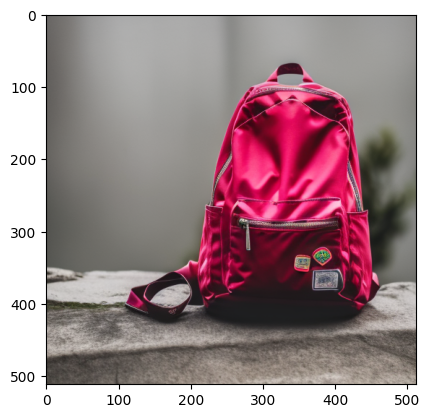

  0%|          | 0/50 [00:00<?, ?it/s]

21 a purple backpack</w> backpack


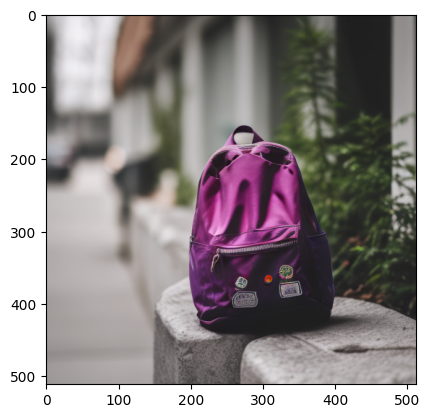

  0%|          | 0/50 [00:00<?, ?it/s]

22 a shiny backpack</w> backpack


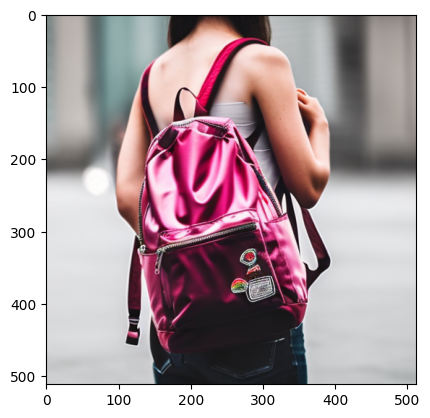

  0%|          | 0/50 [00:00<?, ?it/s]

23 a wet backpack</w> backpack


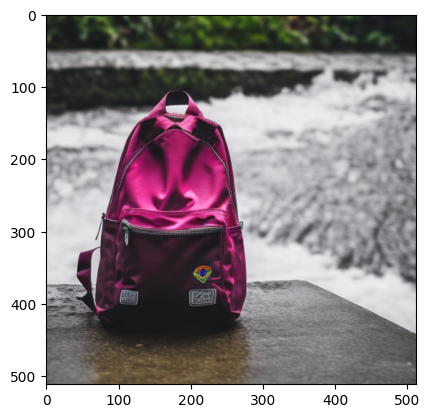

  0%|          | 0/50 [00:00<?, ?it/s]

24 a cube shaped backpack</w> backpack


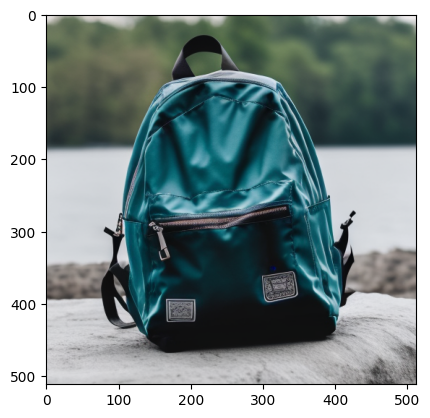

In [4]:
#seed 12, 16, 8, 9 
seed = 12
torch.manual_seed(seed)
save_root = "./generated_pictures"
save_dir = os.path.join(save_root, class_token, "seed"+str(seed))
os.makedirs(save_dir, exist_ok=True)

from visualization import joint_visualization
import matplotlib.pyplot as plt

for m in range(len(prompt_list)):
    prompt = prompt_list[m]
    image = joint_visualization(pipe, img_model, prompt, ref_image, guidance=7.0, eta=0.0, img_adapter=adapter, step=50)[0]
    print(m,prompt)
    plt.imshow(image)
    plt.show() 
    image.save(os.path.join(save_dir, str(m)+".jpg"))

## Obtain the evaluation metrics
Choose the original data path and the generated path, and then you will obtain the corresponding metric

In [5]:
origin_data_path = "/DATA/DATANAS1/chenhong/diffusion_research/dreambooth_data/backpack"
generated_path = save_dir
from evaluation import reconstruction_metric, text_img_match_metric
from evaluator import Evaluator
evalor = Evaluator("cuda:0", model_name='ViT-H-14', source="laion2b_s32b_b79k")
evalor1 = Evaluator("cuda:0", model_name='DINO', source="laion2b_s32b_b79k")
clip_sim = reconstruction_metric(origin_data_path, generated_path, evalor)
DINO_sim = reconstruction_metric(origin_data_path, generated_path, evalor1)
image_text_similarity = text_img_match_metric(generated_path, evalor, unique_token="", class_token=class_token, mode="object")
print("clip image similarity:", clip_sim)
print("DINO image similarity:", DINO_sim)
print("image text similarity:", image_text_similarity)

Using cache found in /home/chenhong/.cache/torch/hub/facebookresearch_dino_main
/home/chenhong/.conda/envs/diffusion/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


clip image similarity: 0.6918267242113749
DINO image similarity: 0.5597899719079336
image text similarity: 0.26651598181989455


## Generation optimization
If you are not satisfied with some of the generations, you can give the index and the new eta for better generation

a backpack</w> backpack on a cobblestone street


  0%|          | 0/50 [00:00<?, ?it/s]

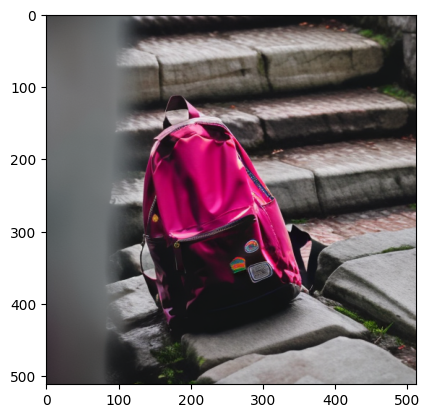

a backpack</w> backpack on top of pink fabric


  0%|          | 0/50 [00:00<?, ?it/s]

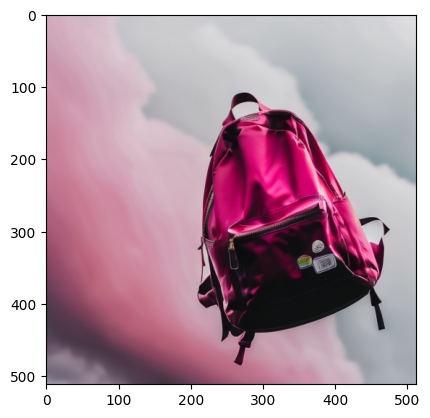

a backpack</w> backpack with a blue house in the background


  0%|          | 0/50 [00:00<?, ?it/s]

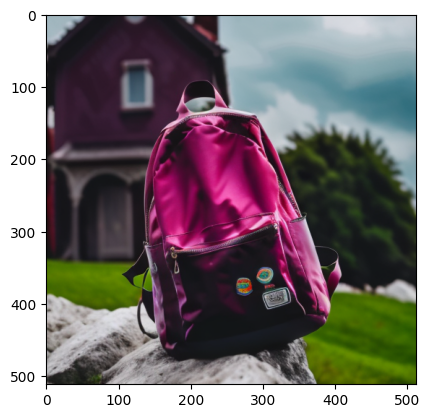

a backpack</w> backpack on top of a purple rug in a forest


  0%|          | 0/50 [00:00<?, ?it/s]

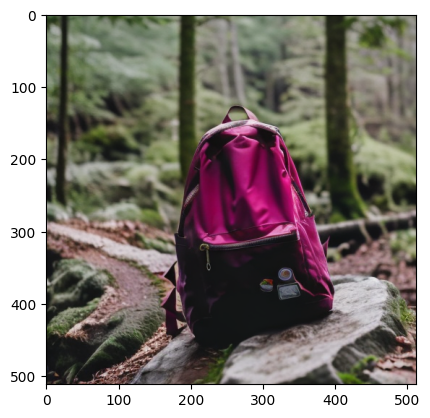

a backpack</w> backpack with the Eiffel Tower in the background


  0%|          | 0/50 [00:00<?, ?it/s]

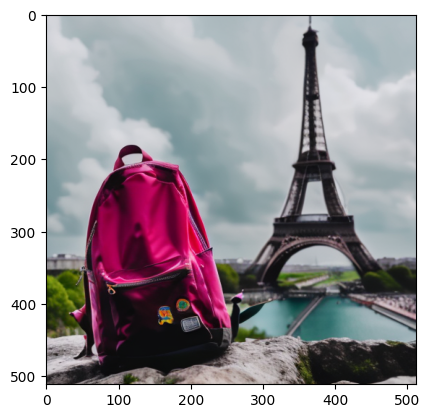

a backpack</w> backpack floating on top of water


  0%|          | 0/50 [00:00<?, ?it/s]

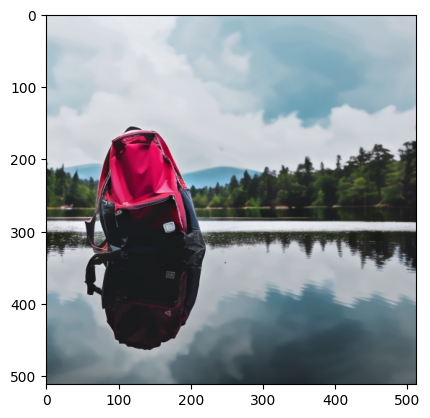

a backpack</w> backpack on top of a white rug


  0%|          | 0/50 [00:00<?, ?it/s]

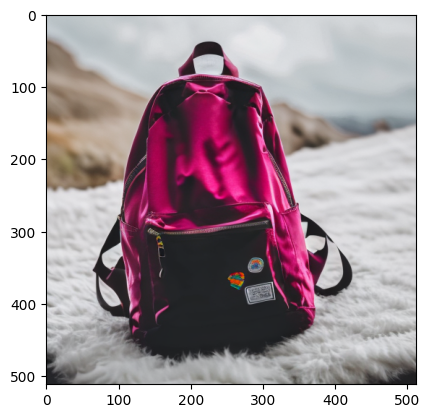

a cube shaped backpack</w> backpack


  0%|          | 0/50 [00:00<?, ?it/s]

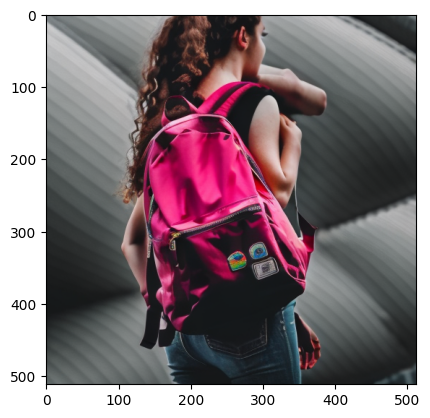

In [7]:
change_index = [3, 4, 8, 9, 12, 13, 19, 24]
change_rate = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
for m in range( len(change_index) ):
    eta_t = change_rate[m]
    prompt = prompt_list[change_index[m]]
    print(prompt)
    image = joint_visualization(pipe, img_model, prompt, ref_image, guidance=7.0, eta=eta_t, img_adapter=adapter, step=50)[0]
    plt.imshow(image)
    plt.show() 
    image.save(os.path.join(save_dir, str(change_index[m])+".jpg"))

## Metric calculation after the modification
You can calculate the new metric after you adjust the etas

In [8]:
clip_sim = reconstruction_metric(origin_data_path, generated_path, evalor)
DINO_sim = reconstruction_metric(origin_data_path, generated_path, evalor1)
image_text_similarity = text_img_match_metric(generated_path, evalor, unique_token="", class_token=class_token, mode="object")
print("clip image similarity:", clip_sim)
print("DINO image similarity:", DINO_sim)
print("image text similarity:", image_text_similarity)

clip image similarity: 0.7084357372919718
DINO image similarity: 0.579913617571195
image text similarity: 0.27069736851586235
